# ALEX DELEON

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm, skew,lognorm,kstest
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import scatter_matrix
from statsmodels.formula.api import ols
import statsmodels.api as sm
from scipy.stats.distributions import *
import os
from scipy.stats import norm, skew,lognorm,kstest
from scipy import stats
from numpy import log1p,log,sqrt,arcsin,square
import scipy
import math
import matplotlib as mpl

from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from scipy.stats import levene
from scipy.stats import chi2
import jenkspy

In [2]:
def dist_check(df, resp_var,p=None,dist=norm,trans = {}):

    fig, axs = plt.subplots(ncols=2,figsize = (14,8) )
    (mu, sigma) = norm.fit(df[resp_var])
    if trans:
        sns.distplot(df[resp_var].apply(trans) , fit=dist, ax=axs[0])
#         stats.probplot(df[resp_var].apply(trans), plot=axs[1])
        sm.qqplot(df[resp_var].apply(trans), ax=axs[1],fit=True,line='r')
    else:
        sns.distplot(df[resp_var] , fit=dist, ax=axs[0])
#         stats.probplot(df[resp_var], plot=axs[1])
        sm.qqplot(df[resp_var], ax=axs[1],fit=True,line='r')
    print (p)
    if p:
        axs[0].legend(['Normal dist. ($\mu=$ {:.2f}, $\sigma=$ {:.2f}, p = {:.4f})'.format(mu, sigma,p)],loc='best')
    else:
        axs[0].legend(['Normal dist. ($\mu=$ {:.2f}, $\sigma=$ {:.2f})'.format(mu, sigma)],loc='best')
    axs[0].set_ylabel( 'Frequency',fontsize = 16)
    axs[0].set_xlabel( resp_var,fontsize = 16)
    axs[0].set_title(resp_var + ' distribution',fontsize = 20)

#     axs[1].set_xlabel('Theoretical Proportions',fontsize = 16)
#     axs[1].set_ylabel('Sample Proportions',fontsize = 16)
#     axs[1].set_title('Normal PP-Plot of ' + resp_var, fontsize = 20)
    
    axs[1].set_xlabel('Theoretical Quantiles',fontsize = 16)
    axs[1].set_ylabel('Sample Quantiles',fontsize = 16)
    axs[1].set_title('Normal QQ-plot of ' + resp_var, fontsize = 20)
    
    fig.tight_layout(pad=3.0)
    plt.show()

    
def shapiroWilk(df,trans ={}):
    under05 = []
    normalized = []
    df = df.select_dtypes(include=['int64','float64'])
    for col in df.columns:
        if col not in ['GEOID_COUNTY','geometry']:
            if trans and col in trans:
                statistic, p = stats.shapiro(df[col].apply(trans[col]))
                if p < .05:
                    print (p)
                    under05.append(col)
                    dist_check(df,col,p,dist=norm,trans=trans[col])
                else:
                    dist_check(df,col,p,dist=norm,trans=trans[col])
                    normalized.append(col)
            else:
                statistic, p = stats.shapiro(df[col])
                if p < .05:
                    under05.append(col)
                    dist_check(df,col,p,dist=norm)
                else:
                    normalized.append(col)
                    dist_check(df,col,p,dist=norm)
                
    return ({'FAILED_WILK':under05,
             'PASSED_WILK':normalized})

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
def calc_vif(df):
    vif = pd.DataFrame()
    df = add_constant(df.select_dtypes(include=['int64','float64']))
    vif["VIF Factor"] = [variance_inflation_factor(np.array(df.values,dtype = float), i) for i in range(df.shape[1])]
    vif["features"] = df.columns
    return vif.sort_values(by = 'VIF Factor')

def mahalanobis(data,chi_test = False,**kwargs):
    x_minus_mu = data - data.mean()
    cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    data['mahal'] =mahal.diagonal()
    if chi_test:
        fig, axs = plt.subplots(ncols=1,figsize = (10,8) )
        sm.qqplot(data['mahal'] ,dist=chi2,distargs = (data.shape[1]-1,),fit=True,line='r',ax=axs)
        axs.set_xlabel('Theoretical Quantiles',fontsize = 16)
        axs.set_ylabel('Sample Quantiles',fontsize = 16)
        if 'title' in kwargs: 
            axs.set_title('Chi-Squared QQ-plot of Mahalanobis Distances of {}'.format(kwargs['title']), fontsize = 20)
        else:
            axs.set_title('Chi-Squared QQ-plot of Mahalanobis Distances', fontsize = 20)
        
    return data

def residuals_normality_check(residuals):
    fig = plt.figure(1, figsize=(9, 6))

    # Create an axes instance
    ax = fig.add_subplot(111)
    ax.set_title('Box Plot of Residuals')

   # Create the boxplot
    bp = ax.boxplot(residuals)
    
cumulative_chi_prob = chi2.ppf(.99, 3)

def residual_diagnostics(df,model,breusch_pagan_test = True, forsythe=True,white_test = True, alpha = .05):
    
    df['yhat'] = model.fittedvalues
    df['res'] = model.resid
    params = [param for param in model.params.index.to_list() if param.lower() not in ['const','intercept']]
    params = params + ['yhat']
    rows = 1 + math.floor(len(params)/2)
    fig = plt.figure(figsize = (15,len(params) + 7))
    spec = mpl.gridspec.GridSpec(ncols = 2, nrows=rows) # 6 columns evenly divides both 2 & 3
    axes = [(i,j) for i in range(rows) for j in [0,1]][:len(params)]
    axes_dict = dict(zip(params,axes))
    keys = list(axes_dict.keys())
    
    if len(keys) % 2 != 0:
        axes_dict[keys[-1]] = (axes_dict[keys[-1]][0],0,1)
    for col,ax in axes_dict.items():
        if len(ax) == 3:
            ax = fig.add_subplot(spec[ax[0],:])
        else:
            ax = fig.add_subplot(spec[ax[0],ax[1]])
            
        ax.scatter(y = df['res'], x =df[col]) 
        ax.set(ylabel='residuals', xlabel=col )
        ax.set_title('residuals vs {}'.format(col))
        ax.axhline(0,linestyle='--',alpha=.6,color='red')
    fig.tight_layout()
    tests_df = []
    
    if breusch_pagan_test:
        bp_test = het_breuschpagan(model.resid, df[params[:2]])
        labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
        
        bp_test_results = dict(zip(labels, bp_test))
        bp_test_results['CHIPROB'] = chi2.ppf(1 - alpha, len(params))
        bp_test_results['PASS']= 'FALSE' if bp_test_results['LM-Test p-value']<0.05 else 'TRUE'
        bp_test_df =  pd.DataFrame.from_dict(bp_test_results, orient='index', columns=['Value'])
        bp_test_df.index.name = 'Breusch Pagan'
        tests_df.append(bp_test_df)
    if forsythe:
        lower,upper=np.array_split(df.sort_values(by='res'),2)
        n=df.shape[0]
        group1 = lower['res'].apply(lambda x: abs(x-lower['res'].median()))
        group2 = upper['res'].apply(lambda x: abs(x-upper['res'].median()))
        group1_sumdevs = group1.apply(lambda x: (x - group1.mean())**2).sum()
        group2_sumdevs = group2.apply(lambda x: (x - group2.mean())**2).sum()
        pool_variance = (group1_sumdevs + group2_sumdevs)/(n-2)
        t_stat = (group1.mean() - group2.mean())/(sqrt(pool_variance)*sqrt(1/40 +1/41))
        cumulative_t_prob = t.ppf(1-alpha/2,n-2)
        passed_test=abs(t_stat)<cumulative_t_prob
        forsythe_df=pd.DataFrame({'T_STAT':[t_stat],'CRITICAL_VALUE':[cumulative_t_prob],'PASS':[passed_test]}).transpose().rename(columns={0:'Value'})
        forsythe_df.index.name = 'Brown Forsythe'
        tests_df.append(forsythe_df)
    return tests_df

def encode_quantiles(df,cols):
    if not isinstance(cols,list):
        cols=[cols]
    for col in cols:
        quants=np.quantile(df[col], [0,.25,.50,.75,1])
        print (quants)
        quan_col='{}_QUAN'.format(col)
        print (quan_col)
        df[quan_col]=1
        for i in range(4):
            lower=quants[i]
            upper=quants[i+1]
            mask= (df[col]>lower)&(df[col]<=upper)
            df.loc[mask,quan_col]=i+1
    return df

def jenksClass(df,cols,breaks_num):
    if not isinstance(cols,list):
        cols=[cols]
    for col in cols:
        print (cols)
        breaks = jenkspy.jenks_breaks(df[col], nb_class=breaks_num)
        print(breaks)
        print ([i for i in range(breaks_num)])
        df[col+'_JENKS'] = pd.cut(df[col],
                                  bins=breaks,
                                  labels=[str(i+1) for i in range(breaks_num)],
                                  include_lowest=True).astype(int)
    return df

def boxplot(col_,resp,df):
    fig, axs = plt.subplots(1)
    df2 = pd.DataFrame({col:vals[resp] for col, vals in df.groupby(col_)})
    meds = df2.median().sort_values()
    df2[meds.index].boxplot(rot=45,figsize = (12,7), grid = False, fontsize = 16, ax = axs)
    plt.xticks(rotation=45)
    fig.set_size_inches(14, 10)
    fig.tight_layout(pad=3.0)
    axs.set_ylabel(resp,fontsize='xx-large', fontname='monospace')
    axs.set_xlabel(col_,fontsize='xx-large',fontname='monospace' )
    axs.set_title("{} by ".format(resp) + col_ ,fontsize='xx-large',fontname='monospace' )
    axs.tick_params(axis='x', labelsize= 22 )
    axs.tick_params(axis='y', labelsize= 22)
    axs.xaxis.get_label().set_fontsize(24)
    axs.yaxis.get_label().set_fontsize(24)
    axs.title.set_fontsize(28)
    
def forward_selected(data, response):

    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))

            score = ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = ols(formula, data).fit()
    return model

In [66]:
ind_vars=['ZIPCODE','INF_RATE','DEATH_RATE','DIS_PER','OVER65_PER', 
          'NOINSUR','RENT35PER', 'GROUPQ_PER','AVG_HH',
          'ESS_WRK','HIGHCHOL'
         ]

### Shapiro Wilks is used to test the response variable(s) covid infection rates (total cases over total population as DEATH_RATE) and covid case mortality rate (total deaths over total cases as INF_RATE) for normality. QQ and frequency plots were used as a visual aid for this test. INF_RATE and DEATH_RATE failed Wilks test with p-values less than 0.05. Judging for the QQ-plots, outliers are present.

0.010978952050209045


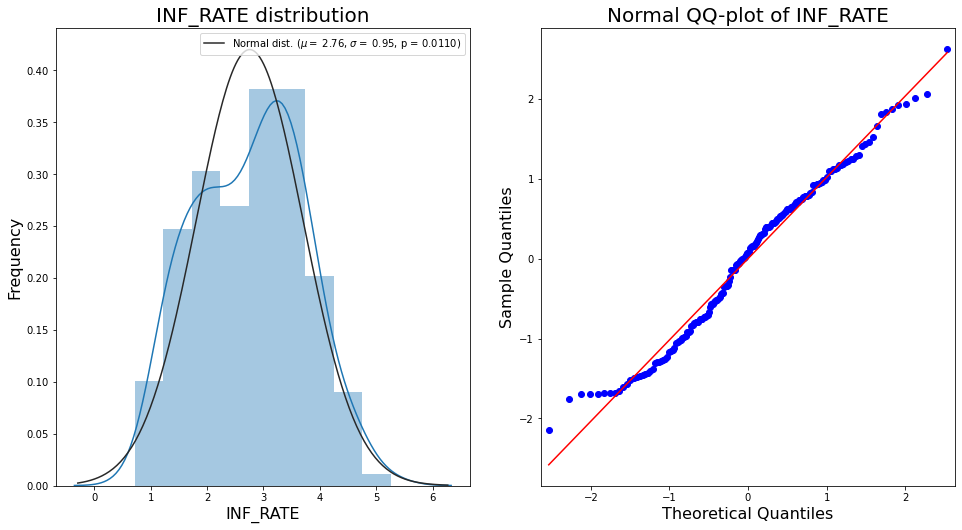

0.001756007201038301


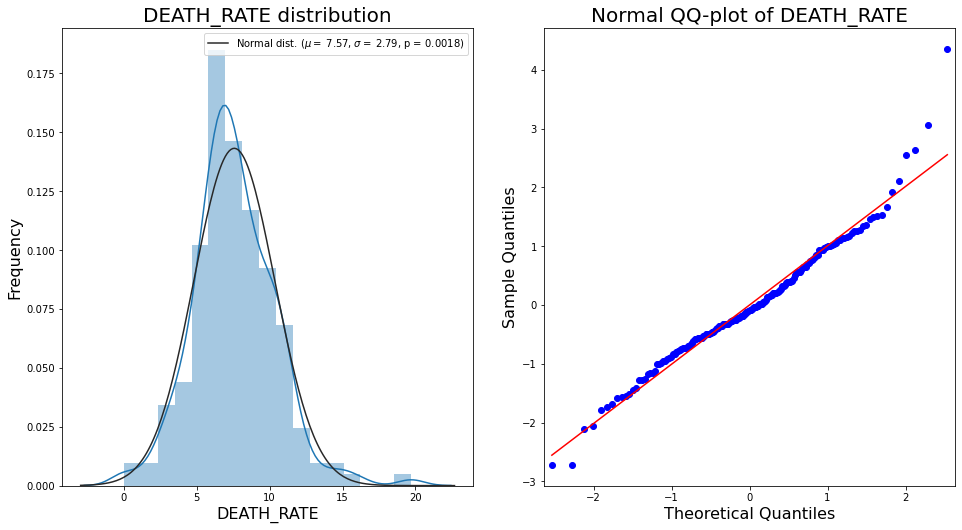

{'FAILED_WILK': ['INF_RATE', 'DEATH_RATE'], 'PASSED_WILK': []}

In [67]:
zip_data_covid_orig=pd.read_csv(r'C:\Users\16464\Desktop\FALL 2020\SEMINAR\DATA\ZIP\ZIP_DATA\ZIP_DATA_GWR.csv')
zip_data_covid=zip_data_covid_orig[ind_vars]
shapiroWilk(zip_data_covid[['INF_RATE','DEATH_RATE']])

In [64]:
#zip_data_covid=jenksClass(zip_data_covid,['AST_LIV_BEDS','NH_BEDS','AST_NH_BEDS','OCC_BEDS'],4)
# boxplot('AST_LIV_BEDS_JENKS','DEATH_RATE',zip_data_covid)
# boxplot('NH_BEDS_JENKS','DEATH_RATE',zip_data_covid)
# boxplot('AST_NH_BEDS_JENKS','DEATH_RATE',zip_data_covid)
# boxplot('OCC_BEDS_JENKS','DEATH_RATE',zip_data_covid)

[  0.   0.  70. 265. 816.]
AST_NH_BEDS_QUAN


C:\Users\16464\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\16464\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\16464\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

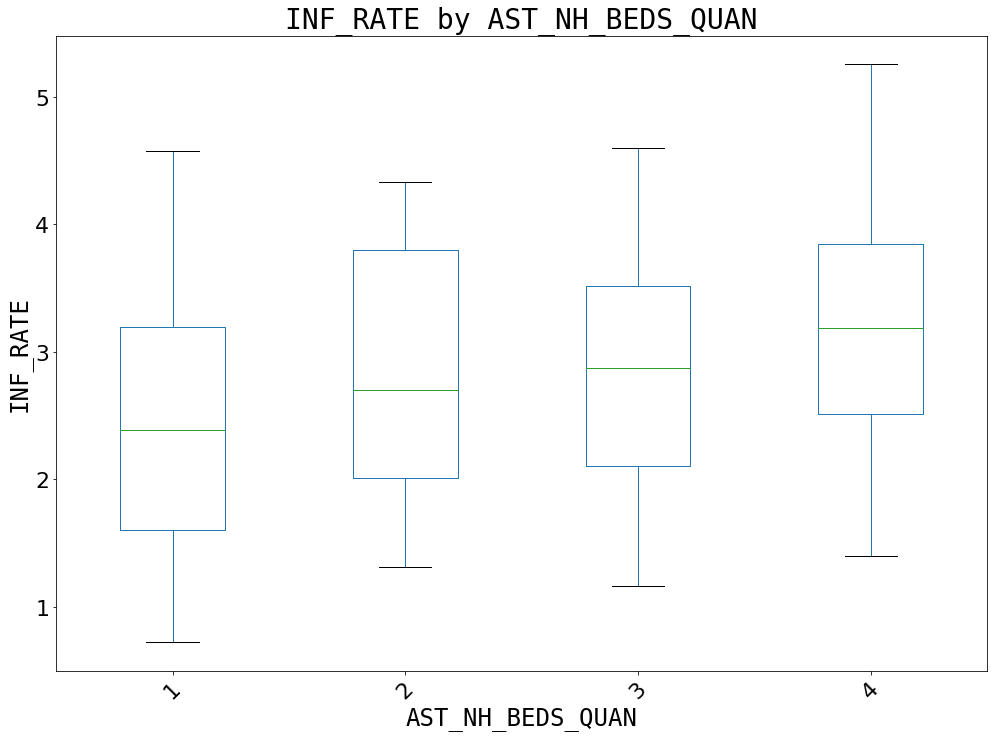

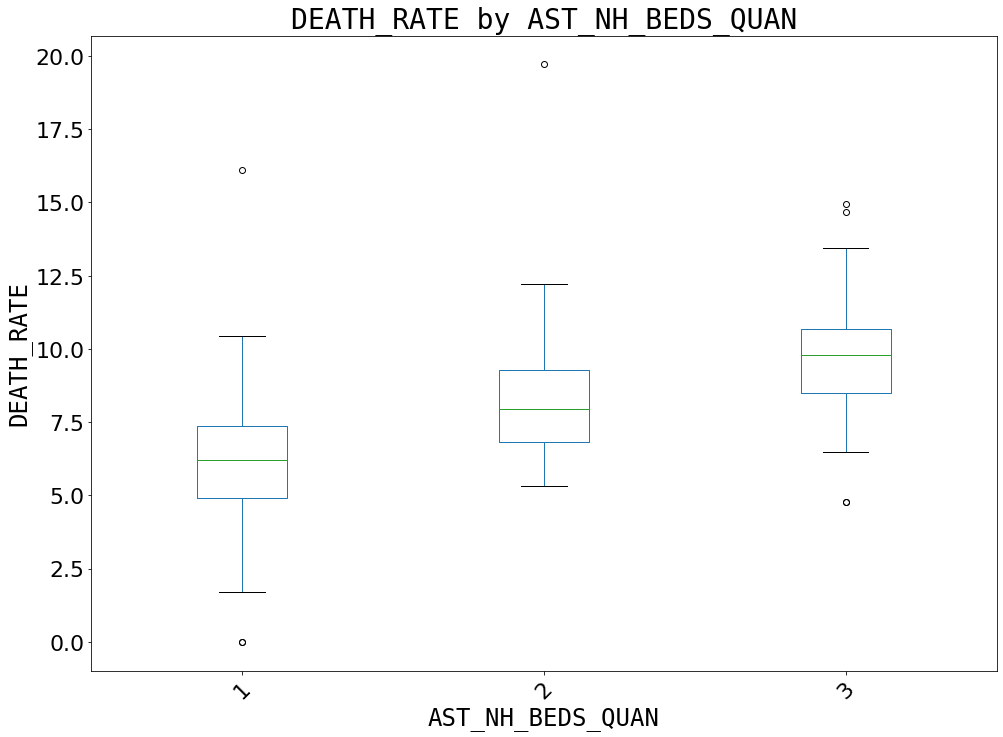

In [65]:
zip_data_covid=encode_quantiles(zip_data_covid,'AST_NH_BEDS')
# boxplot('AST_LIV_BEDS_QUAN','DEATH_RATE',zip_data_covid)
# boxplot('NH_BEDS_QUAN','DEATH_RATE',zip_data_covid)
boxplot('AST_NH_BEDS_QUAN','INF_RATE',zip_data_covid)
zip_data_covid['AST_NH_BEDS_QUAN']=zip_data_covid['AST_NH_BEDS_QUAN'].replace([1,2,3,4],[1,1,2,3])
boxplot('AST_NH_BEDS_QUAN','DEATH_RATE',zip_data_covid)

In [66]:
# zip_data_covid=jenksClass(zip_data_covid,'CARPOOL',2)
# zip_data_covid["CARPOOL_JENK"]=zip_data_covid["CARPOOL_QUAN"].replace(4,3)
# boxplot('CARPOOL_JENK','INF_RATE',zip_data_covid)
# boxplot('CARPOOL_JENK','DEATH_RATE',zip_data_covid)

### Variance Inflation Factor (VIF) is used to access the presence of multicollinearity. After removing and combining a number of variables, the highest VIF factor is approximately 9. The following changes were made. Percentage of households without internet was removed due to its high correlation with percentage of households without a computer. Additionally, percentage of people without a high school diploma was removed because it highly correlated with percent of essential workers. Lastly, since the number of liquor or wine stores (grocery stores that sell beer/cider were removed) and the number of foodstores were highly correlated, they were combined to create a "Points of Interest" as POI variable. This variable is represented of locations that people typically frequent to purchase consumable products.

In [67]:
# corr = zip_data_covid['COVID_CASE_RATE','COVID_DEATH_RATE','LAUNDRY','WORSHIP','BARB_SALON',
#                                'LIQUOR',
#                                'FOODSTORES'].corr()
# corr.style.background_gradient(cmap='coolwarm')

In [86]:
zip_data_covid.columns

Index(['ZIPCODE', 'COVID_CASE_RATE', 'COVID_DEATH_RATE', 'INF_RATE',
       'DEATH_RATE', 'DIS_PER', 'OVER65_PER', 'NOINSUR', 'RENT35PER',
       'GROUPQ_PER', 'AVG_HH', 'AST_NH_BEDS', 'ESS_WRK', 'BINGE_CrudePrev_PER',
       'BINGE_CrudePrev_PER', 'BPHIGH_CrudePrev_PER', 'CSMOKING_CrudePrev_PER',
       'HIGHCHOL_CrudePrev_PER'],
      dtype='object')

### 

In [68]:
data=zip_data_covid.drop(columns=[
                                  'ZIPCODE',
                                  
                                 ]
                        )
                           
X=data.drop(columns=['INF_RATE',
                     'DEATH_RATE'
                    ]
                     )

In [69]:
X.columns

Index(['DIS_PER', 'OVER65_PER', 'NOINSUR', 'RENT35PER', 'GROUPQ_PER', 'AVG_HH',
       'ESS_WRK', 'HIGHCHOL'],
      dtype='object')

# SELECTING VARIABLES WITH FORWARD STEP WISE

## (1) STEPWISE MODELING INF_RATE

In [17]:
data.columns

Index(['INF_RATE', 'DEATH_RATE', 'DIS_PER', 'OVER65_PER', 'NOINSUR',
       'RENT35PER', 'GROUPQ_PER', 'AVG_HH', 'ESS_WRK', 'BINGE', 'BPHIGH',
       'CSMOKING', 'HIGHCHOL'],
      dtype='object')

In [38]:
model=forward_selected(data.drop(columns=['DEATH_RATE']),"INF_RATE")

In [39]:
params=sorted(model.params.reset_index().iloc[1:]['index'].tolist())
params

['AVG_HH', 'BPHIGH', 'DIS_PER', 'GROUPQ_PER', 'NOINSUR', 'RENT35PER']

In [40]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               INF_RATE   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     48.11
Date:                Wed, 09 Dec 2020   Prob (F-statistic):           3.45e-34
Time:                        18:26:36   Log-Likelihood:                -154.22
No. Observations:                 177   AIC:                             322.4
Df Residuals:                     170   BIC:                             344.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.7054      0.280     -6.098      0.000      -2.257      -1.153
BPHIGH         0.0316      0.013      2.398      0.018       0.006       0.058
AVG_HH         0.7466      0.127      5.893      0.000       0.496       0.997
DIS_PER        0.0693      0.019      3.574      0.000       0.031       0.108
RENT35PER      0.0239      0.008      2.942      0.004       0.008       0.040
GROUPQ_PER     0.0252      0.014      1.799      0.074      -0.002       0.053
NOINSUR       -0.0233      0.016     -1.465      0.145      -0.055       0.008
==============================================================================
Omnibus:                        8.108   Durbin-Watson:                   1.199
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                8.001
Skew:                           0.450   Prob(JB):                       0.0183
Kurtosis:                       3.525   Cond. No.                         348.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## VIF

In [27]:
calc_vif(X[params])

,VIF Factor,features
4,1.049249,GROUPQ_PER
5,1.861393,NOINSUR
1,2.118138,AVG_HH
3,2.411338,DIS_PER
6,2.738388,RENT35PER
2,3.282923,BPHIGH
0,39.750776,const


In [41]:
X[params].corr()
vars=['BINGE', 'BPHIGH', 'CSMOKING', 'HIGHCHOL']

corr=X[vars].corr()
corr.style.background_gradient(cmap='coolwarm')

KeyError: "['BINGE'] not in index"

## (2) STEPWISE MODELING DEATH_RATE

In [ ]:
model2=forward_selected(data.drop(columns='INF_RATE'),"DEATH_RATE")
params2=sorted(model2.params.reset_index().iloc[1:]['index'].tolist())
model2.summary()


## VIF

In [28]:
calc_vif(X[params2])

NameError: name 'params2' is not defined

# SELECTION WITHOUT STEP WISE. Regress INF_RATE against the variables above.

In [70]:
Y=zip_data_covid['INF_RATE']
Y2=zip_data_covid['DEATH_RATE']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               INF_RATE   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     35.37
Date:                Wed, 09 Dec 2020   Prob (F-statistic):           2.54e-32
Time:                        18:33:29   Log-Likelihood:                -154.67
No. Observations:                 177   AIC:                             327.3
Df Residuals:                     168   BIC:                             355.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9304      0.412     -4.691      0.000      -2.743      -1.118
DIS_PER        0.0804      0.017      4.620      0.000       0.046       0.115
OVER65_PER    -0.0227      0.018     -1.290      0.199      -0.058       0.012
NOINSUR       -0.0372      0.018     -2.126      0.035      -0.072      -0.003
RENT35PER      0.0234      0.008      2.782      0.006       0.007       0.040
GROUPQ_PER     0.0286      0.014      1.971      0.050   -4.67e-05       0.057
AVG_HH         0.6649      0.151      4.393      0.000       0.366       0.964
ESS_WRK        0.0078      0.005      1.468      0.144      -0.003       0.018
HIGHCHOL       0.0479      0.027      1.766      0.079      -0.006       0.101
==============================================================================
Omnibus:                        8.514   Durbin-Watson:                   1.217
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                8.501
Skew:                           0.459   Prob(JB):                       0.0143
Kurtosis:                       3.558   Cond. No.                         567.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
calc_vif(X)

,VIF Factor,features
5,1.109516,GROUPQ_PER
3,2.305670,NOINSUR
7,2.496788,ESS_WRK
1,2.684390,DIS_PER
4,2.930246,RENT35PER
6,3.028473,AVG_HH
2,3.656093,OVER65_PER
8,4.028553,BPHIGH
9,5.977713,HIGHCHOL
0,84.901041,const


## Regressing DEATH_RATE

In [58]:
corr=zip_data_covid[ind_vars].corr()
corr.style.background_gradient(cmap='coolwarm')

,ZIPCODE,INF_RATE,DEATH_RATE,DIS_PER,OVER65_PER,NOINSUR,RENT35PER,GROUPQ_PER,AVG_HH,ESS_WRK,BPHIGH,HIGHCHOL
ZIPCODE,1.000000,0.304821,0.233348,0.027287,0.072426,0.312297,0.351845,-0.211196,0.551678,0.356744,0.269183,0.382474
INF_RATE,0.304821,1.000000,0.193228,0.525371,0.026893,0.349344,0.613560,0.006690,0.619061,0.554019,0.679417,0.558759
DEATH_RATE,0.233348,0.193228,1.000000,0.414939,0.241621,0.257197,0.163445,0.131660,0.048736,0.237182,0.404798,0.369699
DIS_PER,0.027287,0.525371,0.414939,1.000000,0.277264,0.140608,0.313004,0.056114,0.140855,0.356198,0.724392,0.587719
OVER65_PER,0.072426,0.026893,0.241621,0.277264,1.000000,-0.314029,-0.073770,-0.081682,-0.209282,-0.086685,0.215399,0.610275
NOINSUR,0.312297,0.349344,0.257197,0.140608,-0.314029,1.000000,0.661617,-0.086159,0.509730,0.554478,0.291349,0.217006
RENT35PER,0.351845,0.613560,0.163445,0.313004,-0.073770,0.661617,1.000000,-0.071628,0.650593,0.616976,0.554413,0.502896
GROUPQ_PER,-0.211196,0.006690,0.131660,0.056114,-0.081682,-0.086159,-0.071628,1.000000,-0.191163,-0.175365,-0.044785,-0.142248
AVG_HH,0.551678,0.619061,0.048736,0.140855,-0.209282,0.509730,0.650593,-0.191163,1.000000,0.616615,0.484011,0.420145
ESS_WRK,0.356744,0.554019,0.237182,0.356198,-0.086685,0.554478,0.616976,-0.175365,0.616615,1.000000,0.612108,0.392270


### Breusch Pagan and Brown Forsythe tests are used to test for heteroscedasticity. Residual plots were also used as a visual aid for outlier and nonconstant variance patterns. From the residual plots, we see that there are outliers present in percentage of people in group quarters (GROUPQ), the percentage of people who carpool with 4 or more people to work (4CARPOOL), and the number of laundromats.

In [ ]:
res_tests=residual_diagnostics(zip_data_covid,results)

### We fail the Pagan test. This is expected since the Pagan test is typically used for large samples and assums that the X variables have a specific relationship with the error terms.

In [ ]:
res_tests[0]

### Suprisingly, we pass the Brown Forsythe test. Despite passing the Forsythe test, we will perfrom a weighted least regression to imporve the nonconstant error variances.

In [ ]:
res_tests[1]

In [ ]:
# def WLS_wghts(X,model):
#     model = sm.OLS(abs(model.resid),X)
#     results_res = model.fit()
#     return 1/(results_res.fittedvalues)**2

# model = sm.WLS(Y,X,WLS_wghts(X,results))
# results_wghted = model.fit()
# results_wghted.summary()

### DEATH_RATE